In [9]:
import pandas as pd
import pickle

In [10]:
region_name = "Hobart"
base_path = "/g/data/w28/yk8692/nesp"
# events_list = "/scratch/gb02/lk5320/python_scripts/Station_analysis/plots_4_04march2025/p5_shortlist_common_events_based_on_10min.xlsx"  
events_list = f"{base_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv"  
# events_list = "/scratch/gb02/lk5320/python_scripts/Station_analysis/plots_4_04march2025/p5_shortlist_common_events_based_on_1hr.xlsx"  
events_list = pd.read_csv(events_list)
print(events_list)

   Rank        Date                              Station  Latitude  Longitude  \
0     1  2013-12-28  KUNANYI (MOUNT WELLINGTON PINNACLE)  -42.8950   147.2358   
1     2  2013-10-10  KUNANYI (MOUNT WELLINGTON PINNACLE)  -42.8950   147.2358   
2     3  2014-04-01                  HOBART AIRPORT WEST  -42.8339   147.5033   
3     4  2010-03-25  KUNANYI (MOUNT WELLINGTON PINNACLE)  -42.8950   147.2358   
4     5  2004-07-01                  HOBART AIRPORT WEST  -42.8339   147.5033   
5     6  2016-04-01                  HOBART AIRPORT WEST  -42.8339   147.5033   
6     7  2018-05-10  KUNANYI (MOUNT WELLINGTON PINNACLE)  -42.8950   147.2358   
7     8  2004-08-12                  HOBART AIRPORT WEST  -42.8339   147.5033   
8     9  2011-12-19                  HOBART AIRPORT WEST  -42.8339   147.5033   
9    10  2021-12-02                       HOBART AIRPORT  -42.8333   147.5119   

   Daily_Max_10min   Datetime_10min_Max  Daily_Max_1h      Datetime_1h_Max  \
0             58.8  2013-12-28

In [11]:
selected_rows = events_list.iloc[[0, 3, 5, 7]]
selected_rows

,Rank,Date,Station,Latitude,Longitude,Daily_Max_10min,Datetime_10min_Max,Daily_Max_1h,Datetime_1h_Max,Above_99p_1h
0,1,2013-12-28,KUNANYI (MOUNT WELLINGTON PINNACLE),-42.8950,147.2358,58.8,2013-12-28 23:10:00,115.8,2013-12-28 23:50:00,Y
3,4,2010-03-25,KUNANYI (MOUNT WELLINGTON PINNACLE),-42.8950,147.2358,25.4,2010-03-25 14:05:00,59.0,2010-03-25 14:30:00,Y
5,6,2016-04-01,HOBART AIRPORT WEST,-42.8339,147.5033,18.2,2016-04-01 10:50:00,20.0,2016-04-01 10:50:00,Y
7,8,2004-08-12,HOBART AIRPORT WEST,-42.8339,147.5033,17.2,2004-08-12 11:55:00,17.8,2004-08-12 11:55:00,Y


In [12]:
# with open('/scratch/gb02/lk5320/python_scripts/Station_analysis/plots_4_04march2025/p3_all_stations_data.pkl', 'rb') as f:
with open(f'{base_path}/station_corrected_rv/p2_event_windows_noNAN_all_stations_{region_name}.pkl', 'rb') as f:
    all_stations_data = pickle.load(f)
all_stations_data

{'KUNANYI (MOUNT WELLINGTON PINNACLE)': {'10min':                        Time  Precipitation  Temperature  Relative Humidity  \
  0       2000-09-25 12:15:00            NaN          NaN                NaN   
  1       2000-09-25 12:20:00            NaN          NaN                NaN   
  2       2000-09-25 12:25:00            NaN          NaN                NaN   
  3       2000-09-25 12:30:00            NaN          NaN                NaN   
  4       2000-09-25 12:35:00            NaN          NaN                NaN   
  ...                     ...            ...          ...                ...   
  2535113 2024-10-31 23:40:00            0.0        -1.20             95.320   
  2535114 2024-10-31 23:45:00            0.0        -1.20             96.385   
  2535115 2024-10-31 23:50:00            0.0        -1.25             97.095   
  2535116 2024-10-31 23:55:00            0.0        -1.25             97.455   
  2535117 2024-11-01 00:00:00            0.0        -1.20             97

In [13]:
# Ensure datetime format
selected_rows['Time of 10min P'] = pd.to_datetime(selected_rows['Datetime_10min_Max'])

# List to collect DataFrames
daily_data_list = []

# Loop over each event row
for idx, row in selected_rows.iterrows():
    station = row['Station']
    event_time = row['Time of 10min P']
    event_date = event_time.date()  # Get just the date

    # Check station exists in dictionary
    if station in all_stations_data:
        # Get 10min data specifically
        df_station = all_stations_data[station].get('10min')
        if df_station is not None:
            df_station = df_station.copy()
            df_station['Time'] = pd.to_datetime(df_station['Time'])
            df_station.set_index('Time', inplace=True)

            # Slice full day
            day_start = pd.Timestamp(event_date)
            day_end = day_start + pd.Timedelta(days=1)
            day_data = df_station.loc[day_start:day_end - pd.Timedelta(minutes=1)].copy()

            # Add station info for tracking
            day_data['Station'] = station
            day_data['Event Date'] = event_date

            # Store
            daily_data_list.append(day_data)
        else:
            print(f"⚠️ No '10min' data for station '{station}'")
    else:
        print(f"⚠️ Station '{station}' not found in all_stations_data.")

# Combine all daily data
full_day_data = pd.concat(daily_data_list)
full_day_data.reset_index(inplace=True)
full_day_data

/jobfs/145723089.gadi-pbs/ipykernel_2711909/3561523305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows['Time of 10min P'] = pd.to_datetime(selected_rows['Datetime_10min_Max'])


,Time,Precipitation,Temperature,Relative Humidity,Wind Speed,Station,Event Date
0,2013-12-28 00:00:00,0.2,7.55,98.640,25.85,KUNANYI (MOUNT WELLINGTON PINNACLE),2013-12-28
1,2013-12-28 00:05:00,0.2,7.60,98.640,25.10,KUNANYI (MOUNT WELLINGTON PINNACLE),2013-12-28
2,2013-12-28 00:10:00,0.0,7.60,98.640,24.65,KUNANYI (MOUNT WELLINGTON PINNACLE),2013-12-28
3,2013-12-28 00:15:00,0.0,7.55,98.640,24.10,KUNANYI (MOUNT WELLINGTON PINNACLE),2013-12-28
4,2013-12-28 00:20:00,0.0,7.55,98.640,22.65,KUNANYI (MOUNT WELLINGTON PINNACLE),2013-12-28
...,...,...,...,...,...,...,...
1147,2004-08-12 23:35:00,0.0,7.20,63.965,9.75,HOBART AIRPORT WEST,2004-08-12
1148,2004-08-12 23:40:00,0.0,7.15,66.060,9.70,HOBART AIRPORT WEST,2004-08-12
1149,2004-08-12 23:45:00,0.0,7.10,67.000,9.15,HOBART AIRPORT WEST,2004-08-12
1150,2004-08-12 23:50:00,0.0,7.05,66.990,8.25,HOBART AIRPORT WEST,2004-08-12


/jobfs/145723089.gadi-pbs/ipykernel_2711909/848046017.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows['Time of 10min P'] = pd.to_datetime(selected_rows['Time of 10min P'])


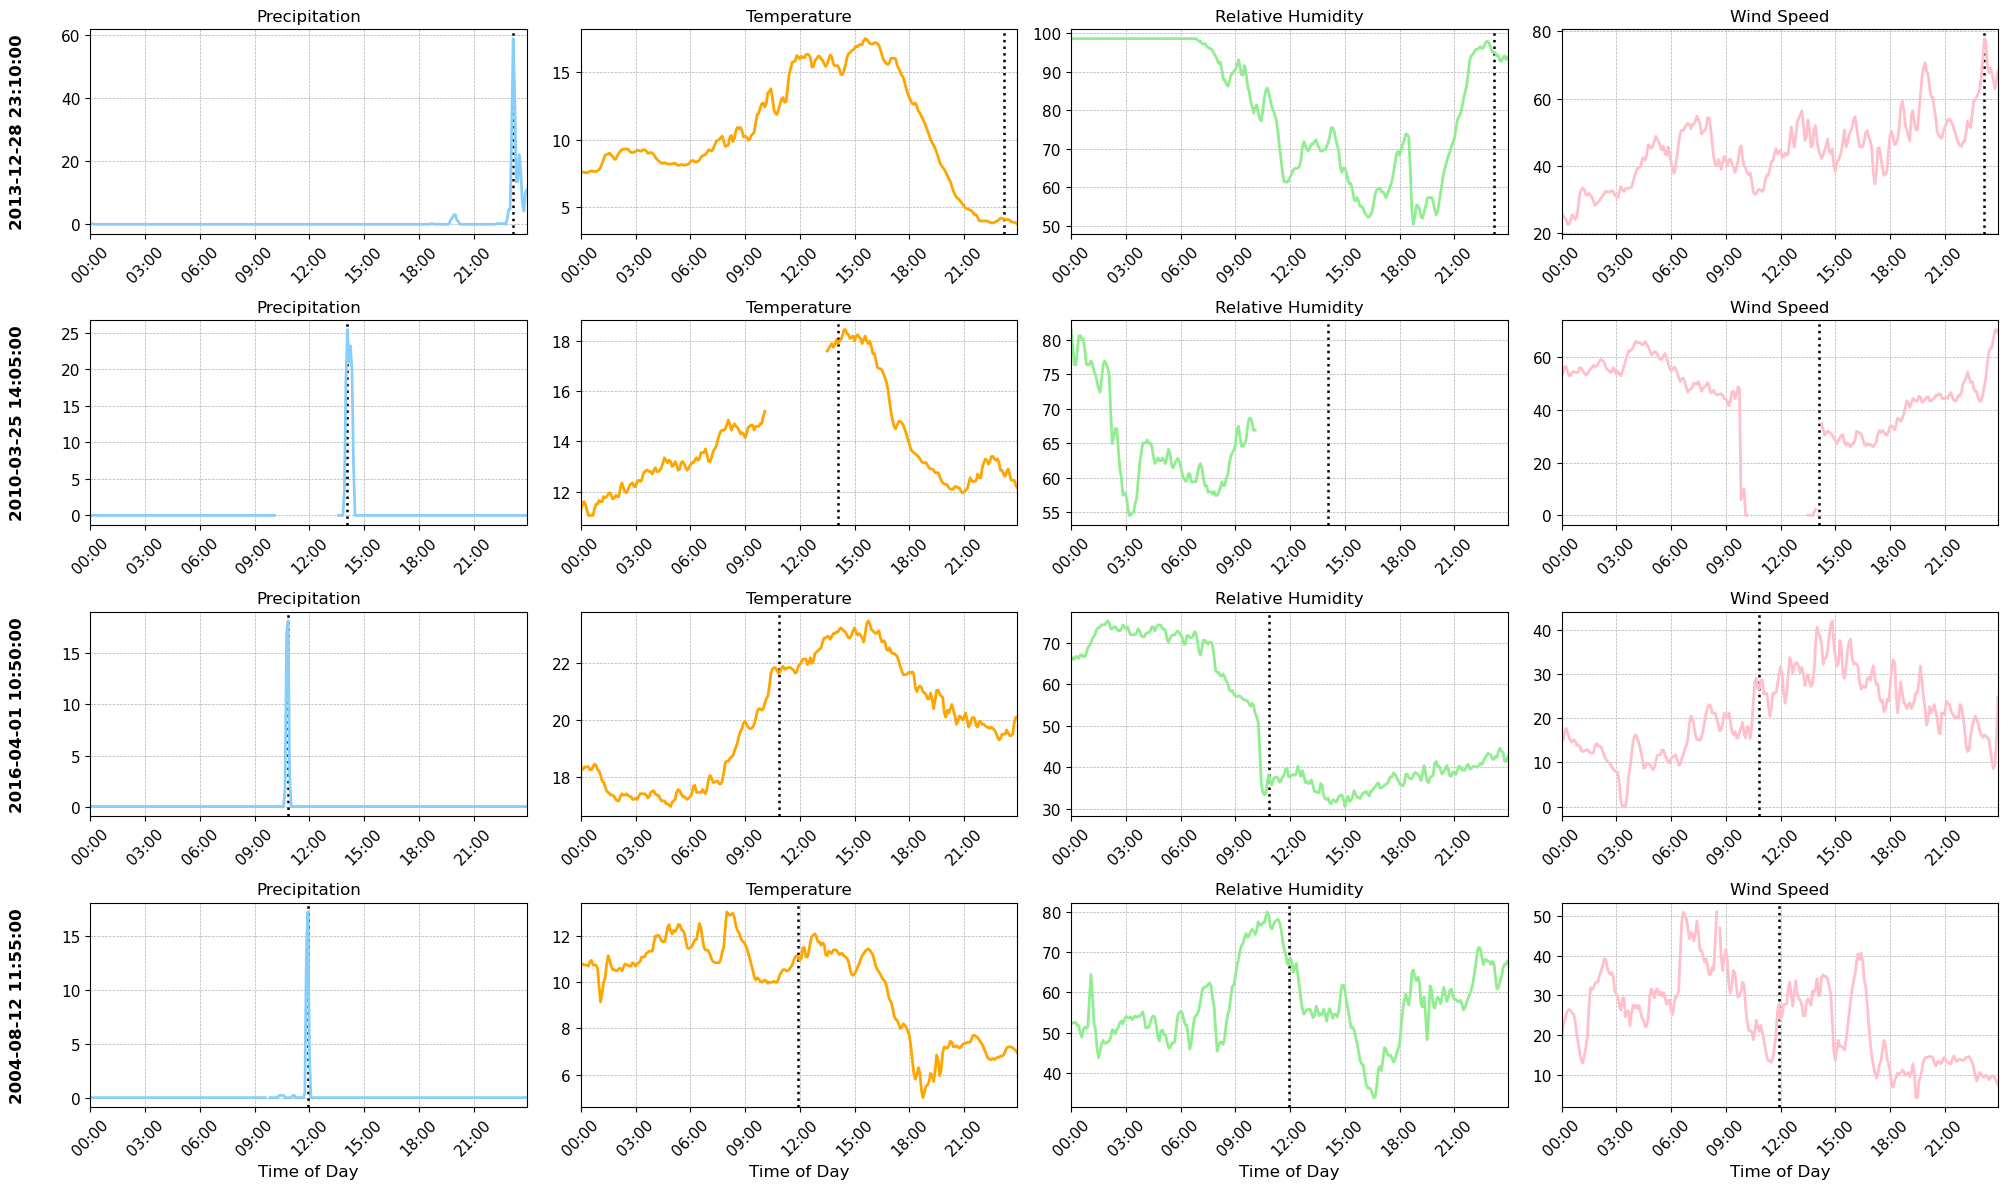

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import string

# Ensure datetime format
full_day_data['Time'] = pd.to_datetime(full_day_data['Time'])
selected_rows['Time of 10min P'] = pd.to_datetime(selected_rows['Time of 10min P'])

# Define variables and colors
variables = ['Precipitation', 'Temperature', 'Relative Humidity', 'Wind Speed']
column_colors = ['lightskyblue', 'orange', 'lightgreen', 'pink']

# Get unique (Station, Event Time) combinations
unique_events = selected_rows[['Station', 'Time of 10min P']].rename(
    columns={'station name': 'Station', 'Time of 10min P': 'Event Time'}
).reset_index(drop=True)

# Limit to first 5 events if more than 5
unique_events = unique_events.head(5)

# Setup figure and subplots
fig, axs = plt.subplots(nrows=len(unique_events), ncols=len(variables), figsize=(20, 3 * len(unique_events)), sharex=False)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Ensure axs is 2D array even for one row
if len(unique_events) == 1:
    axs = axs[np.newaxis, :]

# Loop over events
for row_idx, (_, event) in enumerate(unique_events.iterrows()):
    station = event['Station']
    event_time = event['Event Time']
    event_date = event_time.date()

    # Filter data for the day
    data = full_day_data[(full_day_data['Station'] == station) &
                         (full_day_data['Event Date'] == event_date)].copy()

    for col_idx, (var, color) in enumerate(zip(variables, column_colors)):
        ax = axs[row_idx, col_idx]

        # Event time line
        ax.axvline(event_time, color='black', linestyle=':', linewidth=1.8, label='Event Time')

        # Plot the variable
        ax.plot(data['Time'], data[var], label=var, color=color, linewidth=2)

        # Format x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.set_xlim([data['Time'].min(), data['Time'].max()])
        ax.tick_params(axis='x', labelsize=11, rotation=45)
        ax.tick_params(axis='y', labelsize=11)

        # Subplot title and labels
        ax.set_title(f"{var}" if col_idx == 0 else var, fontsize=12)
        if row_idx == len(unique_events) - 1:
            ax.set_xlabel("Time of Day", fontsize=12)
        if col_idx == 0:
            # ax.set_ylabel(station, fontsize=11, fontweight='bold', labelpad=20)
            ax.set_ylabel(event_time, fontsize=12, fontweight='bold')
            ax.yaxis.set_label_coords(-0.15, 0.5)  # X (left of axis), Y (center)

        ax.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()

# plt.savefig('/scratch/gb02/lk5320/python_scripts/Station_analysis/plots_4_04march2025/p6_wind_during_event_cases.png', format='png', dpi=300, bbox_inches='tight')
plt.savefig(f"{base_path}/figure/{region_name}_top4_all_variables.png", dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure datetime
selected_rows['Time of 10min P'] = pd.to_datetime(selected_rows['Time of 10min P'])

# Build full day data
daily_data_list = []

for idx, row in selected_rows.iterrows():
    station = row['Station name']
    event_time = row['Time of 10min P']
    event_date = event_time.date()

    if station in all_stations_data:
        df_station = all_stations_data[station].copy()
        df_station.index = pd.to_datetime(df_station.index)
        
        # Slice for full event day
        start = pd.Timestamp(event_date)
        end = start + pd.Timedelta(days=1)
        one_day = df_station.loc[start:end - pd.Timedelta(minutes=1)].copy()

        one_day['Station'] = station
        one_day['Event Date'] = event_date
        daily_data_list.append(one_day)
    else:
        print(f"⚠️ Station '{station}' not found in all_stations_data.")

# Combine all into one DataFrame
full_day_data = pd.concat(daily_data_list).reset_index()
full_day_data.rename(columns={'index': 'Time'}, inplace=True)

# Variables and color
variables = ['Precipitation', 'Temperature', 'Relative Humidity', 'Wind Speed']
column_colors = ['lightskyblue', 'orange', 'lightgreen', 'pink']

# Top 5 events
events = selected_rows[['Station name', 'Time of 10min P']].rename(
    columns={'Station name': 'Station', 'Time of 10min P': 'Event Time'}
).head(5)

# Create subplots
fig, axs = plt.subplots(nrows=len(events), ncols=len(variables),
                        figsize=(20, 3 * len(events)), sharex=False)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Handle 1-row case
if len(events) == 1:
    axs = axs[np.newaxis, :]

# Plot each event
for row_idx, (_, event) in enumerate(events.iterrows()):
    station = event['Station']
    event_time = event['Event Time']
    event_date = event_time.date()

    data = full_day_data[(full_day_data['Station'] == station) &
                         (full_day_data['Event Date'] == event_date)].copy()

    for col_idx, (var, color) in enumerate(zip(variables, column_colors)):
        ax = axs[row_idx, col_idx]

        ax.axvline(event_time, color='black', linestyle=':', linewidth=1.8)

        if var in data.columns:
            ax.plot(data['Time'], data[var], label=var, color=color, linewidth=2)

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.set_xlim([data['Time'].min(), data['Time'].max()])
        ax.tick_params(axis='x', labelsize=11, rotation=45)
        ax.tick_params(axis='y', labelsize=11)
        ax.set_title(f"{var}" if col_idx == 0 else var, fontsize=12)

        if row_idx == len(events) - 1:
            ax.set_xlabel("Time of Day", fontsize=12)
        if col_idx == 0:
            ax.set_ylabel(event_time.strftime('%Y-%m-%d %H:%M'), fontsize=12, fontweight='bold')
            ax.yaxis.set_label_coords(-0.15, 0.5)

        ax.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
